In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee
import corner
from getdist import plots, MCSamples
import getdist
from IPython.display import display, Math

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams.update({'font.size': 16})

<font size=6>
    <font color='2a6c14'>
        <font style='bold'>
            
# **Cosmología observacional**
               


<font color='dcyan'>
    <font size=4>
        
## Los datos

### Se trabajará con tres conjuntos de datos. 
#### El primero, titulado "Pantheon_N_CalibrationPantheon.txt" contiene 1048 datos de supernovas del sondeo PANTHEON organizados como $z$, $\mu (z)$, $\sigma_{\mu(z)}$, con $z$ el corrimiento al rojo y $\mu$ el módulo de distancia (a definir abajo)
#### El segundo, titulado "GRB_fulldata_2019" contiene 162 datos de brotes de rayos gamma, organizados $z$, $\mu (z)$, $\sigma_{\mu(z)}$
#### El tercero, titulado "Hz_MarraSapone_2018.txt" contiene 31 datos de cronómetros cósmicos, organizados $z$, $H(z)$, $\sigma_{H(z)}$

Antes de comenzar con la estadística, leamos y observemos los datos con los que contamos.

In [2]:
z, mu, muerr = np.transpose(np.loadtxt('Data/Pantheon_N_CalibrationPantheon.txt', delimiter = ','))
zGRB, muGRB, muerrGRB = np.transpose(np.loadtxt('Data/GRB_fulldata_2019.txt', delimiter = ' '))
zH, H, Herr = np.transpose(np.loadtxt('Data/Hz_MarraSapone_2018.txt', delimiter = ' '))

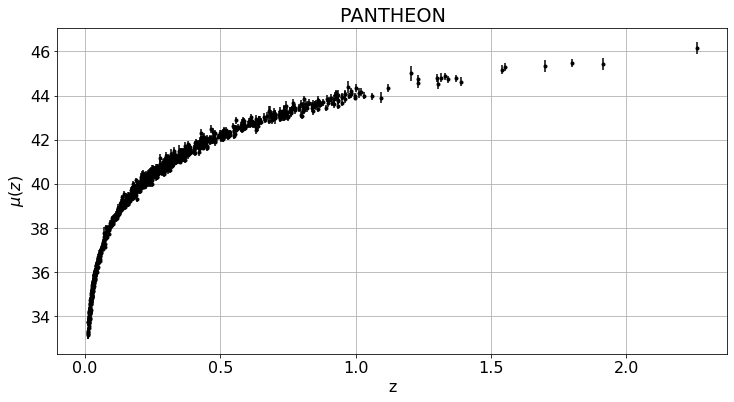

In [3]:
plt.errorbar(z, mu, yerr=muerr, fmt=".k", capsize=0)
plt.xlabel("z")
plt.ylabel("$\mu (z)$")
plt.title('PANTHEON')
plt.grid();

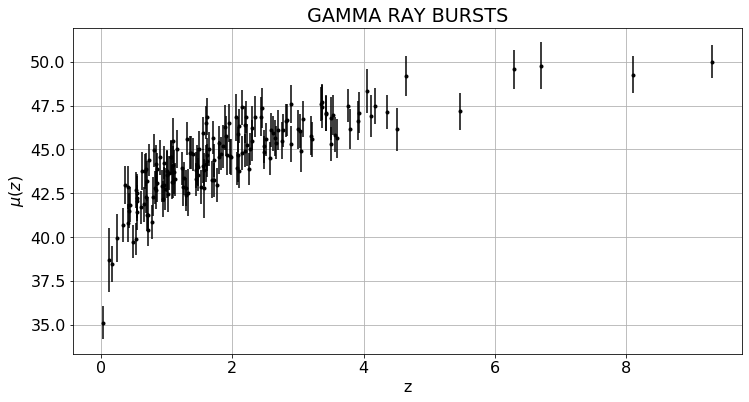

In [4]:
plt.errorbar(zGRB, muGRB, yerr=muerrGRB, fmt=".k", capsize=0)
plt.xlabel("z")
plt.ylabel("$\mu (z)$")
plt.title('GAMMA RAY BURSTS')
plt.grid();

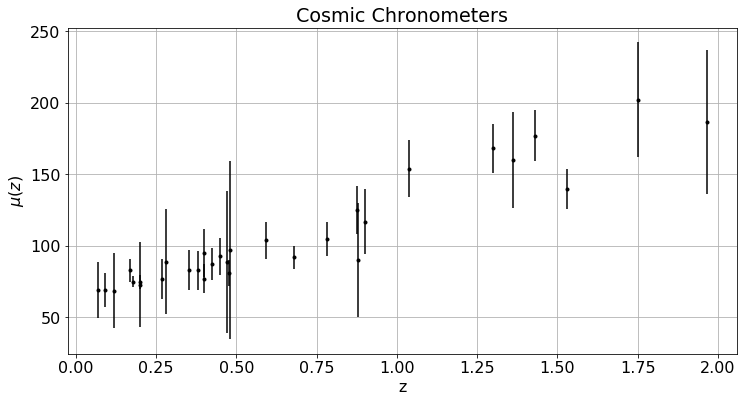

In [5]:
plt.errorbar(zH, H, yerr=Herr, fmt=".k", capsize=0)
plt.xlabel("z")
plt.ylabel("$\mu (z)$")
plt.title('Cosmic Chronometers')
plt.grid();

Es claro que de los tres conjuntos de datos disponibles, el de PANTHEON es el más rico estadísticamente, pues presenta una mayor densidad de datos y cuenta con incertidumbres mucho menores. Trabajar independientemente con Brotes de rayos gamma (GRB por sus siglas en inglés) y con los Cronómetros Cósmicos no parece en primera instancia una buena estrategia para restringir parámetros cosmológicos, sin embargo es interesante combinar sus estadísticas con la de PANTHEON pues ambas presentan distintas ventajas, si se considera que GRB tiene datos con corrimientos al rojo hasta casi z=8, y que CC debe ser ajustada a $H(z)$ y no $\mu(z)$, por lo que respectivamente pueden ayudar a tener una aproximación de mayor orden, o a estudiar la cosmografía con dos distribuciones distintas.

<font color='dcyan'>
    <font size=4>
        
## Determinación de parámetros cosmográficos

## Funciones preliminares

### Datos y modelo estadístico

Se comienza con una forma de evolución a partir de la cual se ajustarán los datos. En este caso se tienen datos del módulo de distancia de las supernovas $\mu(z)$

$$ \mu(z) = 5 \log_{10} \bigg( \dfrac{d_L}{10pc} \bigg)  $$

Donde $d_L$ es la distancia luminosa, donde se introducirá nuestro modelo estadístico. Para el caso de los cronómetros cósmicos, se cuentan con datos del parámetro de Hubble $H(z)$. En ambos casos, el modelo estadístico es independiente del modelo cosmológico pues usaremos la expansión polinomial a partir de los parámetros cosmográficos.

La parametrización de la distancia luminosa con parámetros cosmográficos queda como

$$ d_L(z)=\dfrac{c}{H_0}z\bigg[1+\dfrac{z}{2}(1-q_0) - \dfrac{z^2}{6} \left(1-q_0-3q_0^2+j_0\right)+ \dfrac{z^3}{24} \left( 2-2q_0-15q_0^2-15q_0^3+5j_0+10q_0j_0+s_0 \right) + \mathcal{O}(z^4) \bigg]$$

Mientras que para el parámetro de Hubble es

$$
H(z) = H_0\left(1+(1+q_0)z+\frac{z^2}2(j_0-q_0^2)+\frac{z^3}6(3q_0^2+3q_0^3-4q_0j_0-3j_0-3s_0) + \mathcal{O}(z^4) \right)
$$

Comenzamos el código definiendo estas funciones

In [3]:
def distance(z, H0, q0, j0, s0):
    term1 = 1-q0
    term2 = 1-q0-3*q0**2+j0
    term3 = 2 - 2*q0 -15*q0**2 - 15*q0**3 + 5*j0 + 10*q0*j0 + s0
    d_L = (3e5/H0) * z * (1 + z*term1/2 - z**2 *term2/6 + z**3 *term3 /24)
    return d_L

In [4]:
def H_cosmo(z, H0, q0, j0, s0):
    term1 = 1+q0
    term2 = j0-q0**2
    term3 = 3*q0**2 + 3*q0**3 + 4*q0*j0 -3*j0 -3*s0
    H = H0 * (1 + z*term1 + z**2 *term2/2 + z**3 *term3 /6)
    return H

### Estadística frecuentista

Ahora definimos el logaritmo de la función de verosimilitud dada la estadística $\chi^2$. Es decir, el logaritmo de la probabilidad de obtener un observable $\mu_n(z)$ dados los parámetros de nuestro modelo, la variable $z$ y el error $\sigma$ de nuestra medición:

$$
    \ln\,p(\mu\,|\,z,\sigma,H_0, q_0, j_0, s_0,f) =
    -\frac{1}{2} \sum_n \left[
        \frac{\big(\mu_n-d_L(z,H_0,q_0,j_0,s_0)\big)^2}{\sigma_n^2}
        + \ln \left ( 2\pi\,\sigma_n^2 \right )
    \right]
$$

In [15]:
def log_likelihood(theta, z, mu, muerr):
    H0, q0, j0, s0 = theta
    model = 5*np.log10(distance(z, H0, q0, j0, s0)/1e-5)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

### Estadística bayesiana

In [12]:
def log_prior_cosmo(theta):
    H0, q0, j0, s0 = theta
    if 50.0 < H0 < 80.0 and -10.0 < q0 < 10.5 and -0. < j0 < 10. and -10. < s0 < 10. :
        return 0.0
    return -np.inf

In [13]:
def log_probability_cosmo(theta, x, y, yerr):
    lp = log_prior_cosmo(theta)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(log_likelihood(theta, x, y, yerr)):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

<font color='55570b'>
    <font size=4>
        
## Con datos de supernovas

### Enfoque frecuentista

Dada la definición de nuestra función de verosimilitud, el enfoque frecuentista buscaría los valores de $H_0,\ q_0,\ j_0,\ s_0$ que minimicen la función de verosimilitud. Sin embargo, el número de datos disponibles y de parámetros libres imposibilitan el cálculo numérico de estos valores:

/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


         Current function value: -1446.986689
         Iterations: 1
         Function evaluations: 683
         Gradient evaluations: 113
Maximum likelihood estimates:
H0 = 74.008
q0 = -0.415
j0 = 0.159
s0 = 0.990


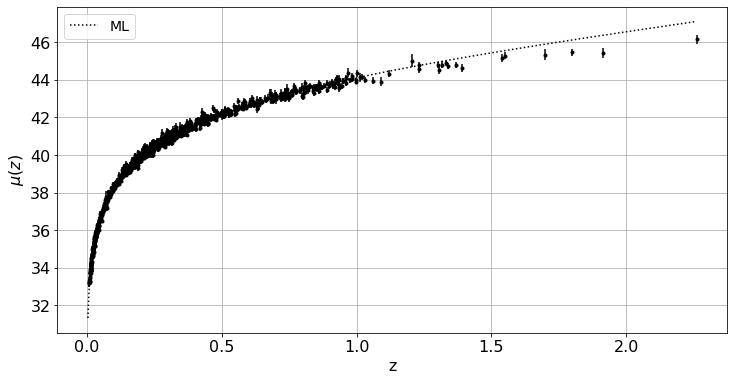

In [16]:
z0 = np.linspace(0, np.max(z), 500)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([74, -0.7, 0.1, 1.0]) #Parámetros que sabemos están cerca de los óptimos
soln_cosmo = minimize(nll, initial, args=(z, mu, muerr), options = {'disp': True}) #Minimizar numéricamenteLeemos los datos de Pantheon que están en un arreglo de 3 columnas $z|\mu(z)|error(\mu)$ y buscamos los parámetros que maximizan la función de verosimilitud. -1*veroizmilitud ->Maximizar verosimilitud
H_ml, q_ml, j_ml, s_ml = soln_cosmo.x

print("Maximum likelihood estimates:")
print("H0 = {0:.3f}".format(H_ml))
print("q0 = {0:.3f}".format(q_ml))
print("j0 = {0:.3f}".format(j_ml))
print("s0 = {0:.3f}".format(s_ml))

plt.errorbar(z, mu, yerr=muerr, fmt=".k", capsize=0)
plt.plot(z0, 5*np.log10(distance(z0, H_ml, q_ml, j_ml, s_ml)/1e-5), ":k", label="ML", markersize = 0.6)
plt.legend(fontsize=14)
plt.xlabel("z")
plt.ylabel("$\mu (z)$")
plt.grid();

Se ve que los valores "optimizados" no se movieron muy lejos de los valores iniciales dados, y que desde la primera iteración del algoritmo se perdió la presición necesaria para continuar el cálculo de la optimización, por lo que debemos recurrir a métodos computacionales más complejos y eficientes, para lo cual es escencial hacer uso de la estadística bayesiana, al incluir un método de Cadena de Markov con la librería emcee.

### Enfoque bayesiano

#### Cosmografía

Creamos caminantes aleatorios y los iniciamos desde los valores óptimos que encontró el enfoque frecuentista 

In [17]:
initial = soln_cosmo.x
pos = initial + 1e-4 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape

np.random.seed(17)
sampler_Pant3 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_cosmo, args=(z, mu, muerr))
sampler_Pant3.run_mcmc(pos, 10000, progress=True);

  0%|          | 35/10000 [00:00<02:28, 67.20it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 10000/10000 [02:23<00:00, 69.81it/s]


Una vez terminado el método, podemos visualizar el recorrido de los caminantes aleatorios

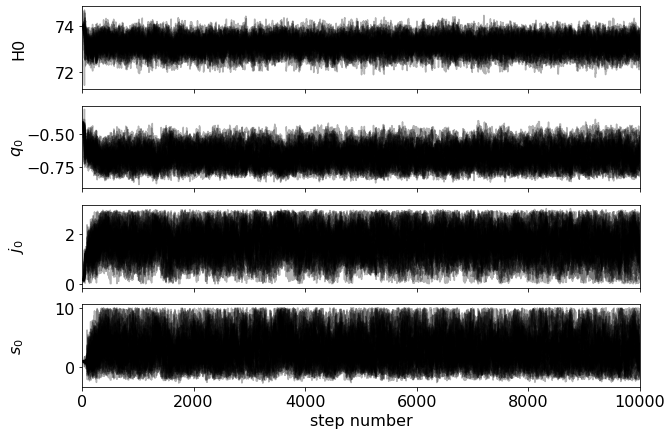

In [18]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_Pant3 = sampler_Pant3.get_chain()
labels = ["H0", "$q_0$", "$j_0$", "$s_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_Pant3[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_Pant3))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Si bien estas gráficas no parecen darnos mucha información más allá de un aproximado de los valores, hay algunas cosas a notar. Primero, al menos cualitativamente $s_0$ parece no estar bien restringido por las observaciones, pues los caminantes recorren prácticamente todo el espacio positivo disponible para ellos. Además, dado que el conjunto de los caminantes aleatorios en su paso $n$ está fuertemente relacionado con las posiciones en su paso $n-1$, los primeros pasos dependen fuertemente del punto inicial. Esto se ve por ejemplo en el caso de $j_0$, pues el valor inicial relacionado está por debajo del camino que siguen en los pasos intermedios y últimos. Es por eso que para obtener resultados eficazmente descartaremos los primeros pasos de la simulación. Usando emcee esto se logra usando el argumento discard en el método get_chain, que recolecta la trayectoria de los caminantes.

#### Resultados

Para obtener el espacio de parámetros se hará uso de las funciones MCSamples y triangle plot de la librería getdist, descartando los primeros pasos de la simulación como recién se discutió. Además, apartir de los porcentiles que cargan los caminates es que estimaremos el valor óptimo encontrado por la simulación y sus incertidumbres

Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

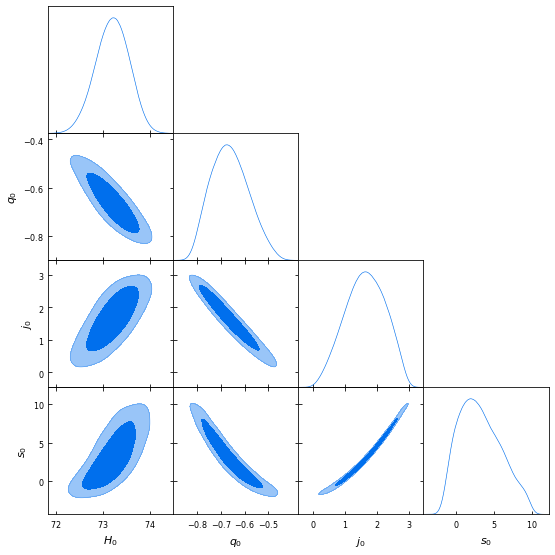

In [19]:
# Definimos las etiquetas de las variables aleatorias
names = ["H_0", "q_0", "j_0", "s_0"]

# Descartamos los primeros pasos para eliminar correlaciones
flat_samples_Pant3 = sampler_Pant3.get_chain(discard=1500, thin=15, flat=True)
samples_Pant3 = MCSamples(samples=flat_samples_Pant3,names = names, labels = names,\
                             label = 'PANTHEON')

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_Pant3], filled=True)

#Imprimimos los valores de los parámetros y sus incertidumbres
for i in range(ndim):
    mcmc = np.percentile(flat_samples_Pant3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names[i])
    display(Math(txt))

Las elipses obtenidas se ven uniformes, podemos observar de las incertidumbres que efectivamente el valor de $s_0$ no está siendo restringido correctamente pues su incertidumbre es mayor que el valor óptimo estimado. Para restringir correctamente los parámetros cosmográficos es necesario entonces ya sea aproximando la distancia luminosa hasta segundo orden o consiguiendo más datos. El camino que seguiremos es unir las observaciones de PANTHEON con las de GRB y CC para tener más datos y que estas estadísticas restrinjan mejor el sistema, pero primero observemos el comportamiento del espacio de parámetros de cada una de las observaciones.

<font color='55570b'>
    <font size=4>
        
## Con datos de brotes de rayos gammas

In [30]:
#initial = np.array([61, 1.71, 1.01, -2.01, np.log(f_true)])
pos = soln_cosmo.x + 1e-4 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape

np.random.seed(21)
sampler_GRB3 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_cosmo, args=(zGRB, muGRB, muerrGRB))
sampler_GRB3.run_mcmc(pos, 80000, progress=True);

  0%|          | 31/80000 [00:00<14:16, 93.34it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 80000/80000 [09:37<00:00, 138.59it/s]


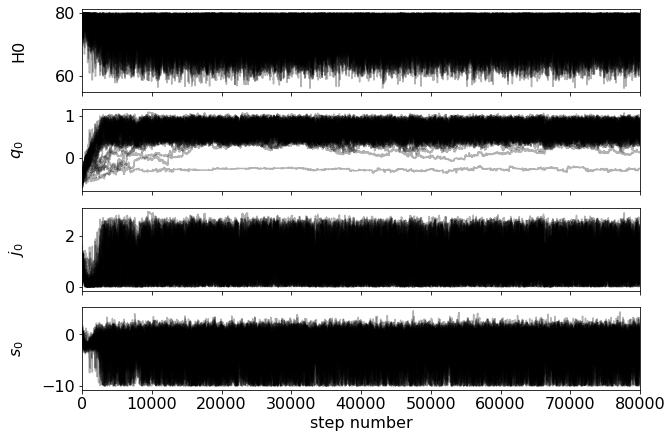

In [31]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_GRB3 = sampler_GRB3.get_chain()
labels = ["H0", "$q_0$", "$j_0$", "$s_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_GRB3[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_GRB3))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

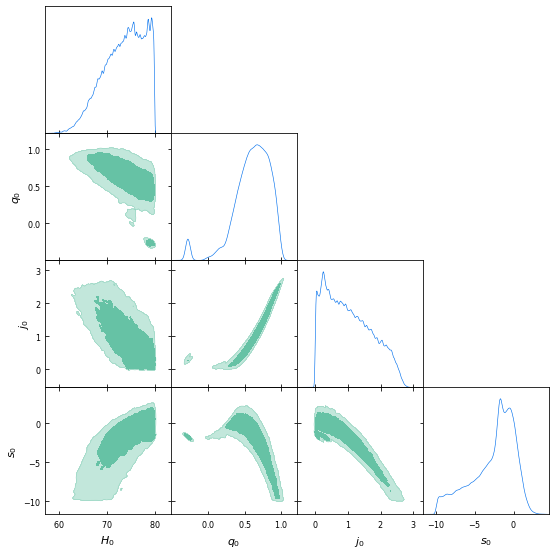

In [32]:
# Descartamos los primeros pasos para eliminar correlaciones
names = ["H_0", "q_0", "j_0", "s_0"]

flat_samples_GRB3 = sampler_GRB3.get_chain(discard=30000, thin=15, flat=True)
samples_GRB3 = MCSamples(samples=flat_samples_GRB3,names = names, labels = names,\
                             label = 'GRB')

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_GRB3], filled=True, colors = 'Set2')

#Imprimimos los valores de los parámetros y sus incertidumbres
for i in range(4):
    mcmc = np.percentile(flat_samples_GRB3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names[i])
    display(Math(txt))

<font color='55570b'>
    <font size=4>
        
## Con datos de cronómetros cósmicos

In [23]:
def log_likelihood_H(theta, z, H, Herr):
    H0, q0, j0, s0 = theta
    model = H_cosmo(z, H0, q0, j0, s0)
    sigma2 = Herr ** 2
    return -0.5 * np.sum((H - model) ** 2 / sigma2 + np.log(sigma2))

In [24]:
def log_probability_H(theta, x, y, yerr):
    lp = log_prior_cosmo(theta)
    ll = log_likelihood_H(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [25]:
initial = np.array([68, -0.6, 1.1, 3.7])
pos = initial + 1e-4 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape

np.random.seed(17)
sampler_H = emcee.EnsembleSampler(nwalkers, ndim, log_probability_H, args=(zH, H, Herr))
sampler_H.run_mcmc(pos, 40000, progress=True);

100%|██████████| 40000/40000 [02:43<00:00, 245.16it/s]


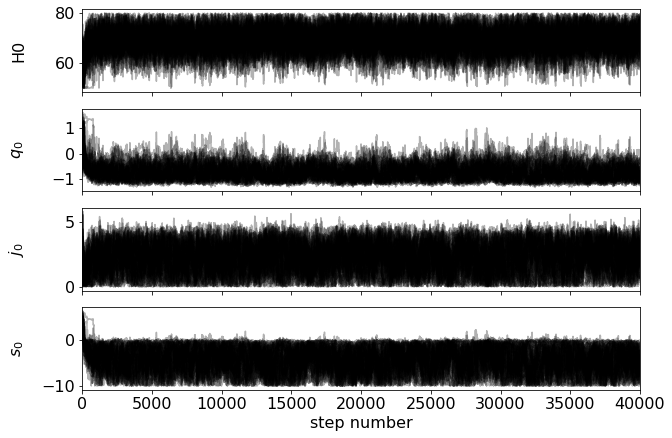

In [26]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_H = sampler_H.get_chain()
labels = ["H0", "$q_0$", "$j_0$", "$s_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_H[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_H))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

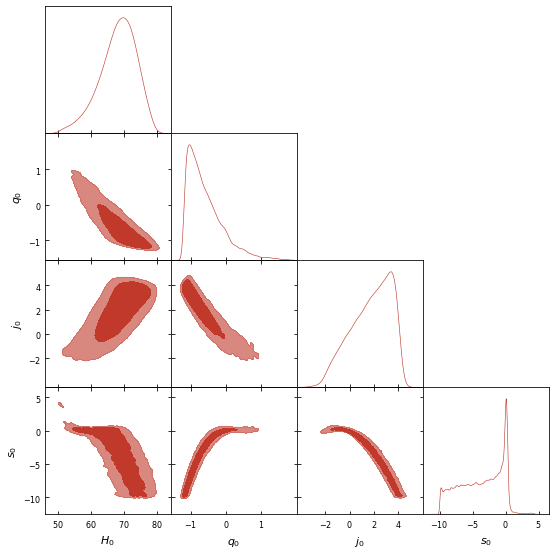

In [22]:
# Descartamos los primeros pasos para eliminar correlaciones
names_H = ["H_0", "q_0", "j_0", "s_0"]

flat_samples_H = sampler_H.get_chain(discard=13000, thin=15, flat=True)
samples_H = MCSamples(samples=flat_samples_H, names = names_H, labels = names_H,\
                             label = 'Cosmic Chronometers')

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_H], filled=True, contour_colors = [('#D98880', '#C0392B')])

#Imprimimos los valores de los parámetros y sus incertidumbres

for i in range(4):
    mcmc = np.percentile(flat_samples_H[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names[i])
    display(Math(txt))

En el caso de CC y GRB nisiquiera el término $j_0$ se restringe bien, por lo que con estos datos apenas se tiene una primera aproximación de la distancia luminosa y el parámetro de Hubble. Sin embargo, uniendo los distintos datos veremos cómo se pueden restringir mucho mejor los parámetros cosmográficos.

<font color='55570b'>
    <font size=4>
        
## Combinando los datos

### PANTHEON y GRB

In [34]:
def log_probability_PantGRB3(theta, x1, y1, y1err, x2, y2, y2err):
    lp = log_prior_cosmo(theta)
    ll1 = log_likelihood(theta, x1, y1, y1err)
    ll2 = log_likelihood(theta, x2, y2, y2err)
    if not np.isfinite(lp) or not np.isfinite(ll1) or not np.isfinite(ll2):
        return -np.inf
    return lp + ll1 + ll2

In [35]:
initial = np.array([68, -0.6, 1.1, 3.7])
pos = initial + 1e-4 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape

np.random.seed(17)
sampler_PantGRB3 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_PantGRB3, args=(z, mu, muerr, zGRB, muGRB, muerrGRB))
sampler_PantGRB3.run_mcmc(pos, 100000, progress=True);

  0%|          | 29/100000 [00:00<24:05, 69.16it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100000/100000 [23:45<00:00, 70.16it/s]   


Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

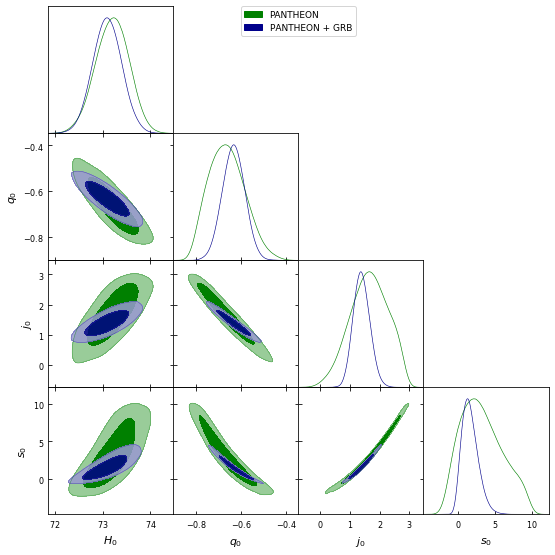

In [25]:
# Descartamos los primeros pasos para eliminar correlaciones
names_PantGRB3 = ["H_0", "q_0", "j_0", "s_0"]

flat_samples_PantGRB3 = sampler_PantGRB3.get_chain(discard=5000, thin=15, flat=True)
samples_PantGRB3 = MCSamples(samples=flat_samples_PantGRB3, names = names_PantGRB3, labels = names_PantGRB3,\
                             label = 'PANTHEON + GRB')

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_Pant3, samples_PantGRB3], filled=True, contour_colors = ['green', 'darkblue'])

#Imprimimos los valores de los parámetros y sus incertidumbres

for i in range(len(flat_samples_PantGRB3[0])):
    mcmc = np.percentile(flat_samples_PantGRB3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names[i])
    display(Math(txt))

### PANTHEON y CC

In [40]:
def log_probability_PantH3(theta, x1, y1, y1err, x2, y2, y2err):
    lp = log_prior_cosmo(theta)
    ll1 = log_likelihood(theta, x1, y1, y1err)
    ll2 = log_likelihood_H(theta, x2, y2, y2err)
    if not np.isfinite(lp) or not np.isfinite(ll1) or not np.isfinite(ll2):
        return -np.inf
    return lp + ll1 + ll2

In [41]:
def log_probability_PantH3(theta, x1, y1, y1err, x2, y2, y2err):
    lp = log_prior_cosmo(theta)
    ll1 = log_likelihood(theta, x1, y1, y1err)
    ll2 = log_likelihood_H(theta, x2, y2, y2err)
    if not np.isfinite(lp) or not np.isfinite(ll1) or not np.isfinite(ll2):
        return -np.inf
    return lp + ll1 + ll2

In [42]:
initial = np.array([68, -0.6, 1.1, 3.7])
pos = initial + 1e-4 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape

np.random.seed(17)
sampler_PantH3 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_PantH3, args=(z, mu, muerr, zH, H, Herr))
sampler_PantH3.run_mcmc(pos, 90000, progress=True);

  0%|          | 29/90000 [00:00<16:12, 92.55it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 90000/90000 [17:14<00:00, 87.00it/s]


Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

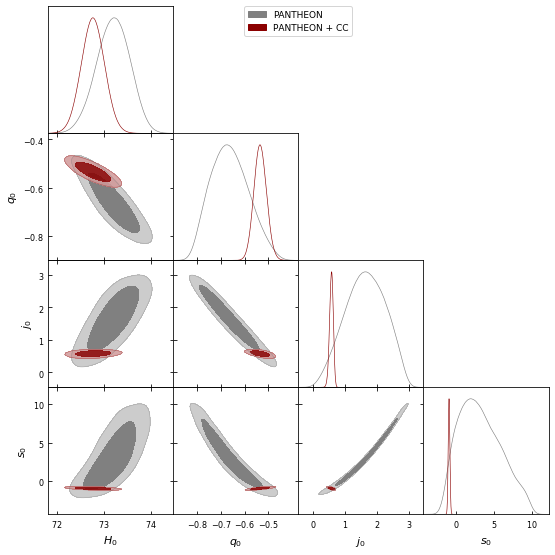

In [43]:
# Etiquetamos las variables
names_PantGRBH3 = ["H_0", "q_0", "j_0", "s_0"]

# Descartamos los primeros pasos para eliminar correlaciones
flat_samples_PantH3 = sampler_PantH3.get_chain(discard=25000, thin=15, flat=True)
samples_PantH3 = MCSamples(samples=flat_samples_PantH3, names = names_PantGRBH3, labels = names_PantGRBH3,\
                             label = 'PANTHEON + CC')

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_Pant3, samples_PantH3], filled=True, contour_colors = ['gray', 'darkred'])

#Imprimimos los valores de los parámetros y sus incertidumbres

for i in range(4):
    mcmc = np.percentile(flat_samples_PantH3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names[i])
    display(Math(txt))

### PANTHEON, GRB y CC

In [46]:
def log_probability_PantH3(theta, x1, y1, y1err, x2, y2, y2err):
    lp = log_prior_cosmo(theta)
    ll1 = log_likelihood(theta, x1, y1, y1err)
    ll2 = log_likelihood_H(theta, x2, y2, y2err)
    if not np.isfinite(lp) or not np.isfinite(ll1) or not np.isfinite(ll2):
        return -np.inf
    return lp + ll1 + ll2

In [47]:
def log_probability_PantGRBH3(theta, x1, y1, y1err, x2, y2, y2err, x3, y3, y3err):
    lp = log_prior_cosmo(theta)
    ll1 = log_likelihood(theta, x1, y1, y1err)
    ll2 = log_likelihood(theta, x2, y2, y2err)
    ll3 = log_likelihood_H(theta, x3, y3, y3err)
    if not np.isfinite(lp) or not np.isfinite(ll1) or not np.isfinite(ll2) or not np.isfinite(ll3):
        return -np.inf
    return lp + ll1 + ll2 + ll3

In [48]:
initial = np.array([72, -0.6, 1.1, 3.7])
pos = initial + 1e-4 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape


np.random.seed(17)
sampler_PantGRBH3 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_PantGRBH3, \
                                          args=(z, mu, muerr, zGRB, muGRB, muerrGRB, zH, H, Herr))
sampler_PantGRBH3.run_mcmc(pos, 80000, progress=True);

  0%|          | 32/80000 [00:00<18:25, 72.35it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
 23%|██▎       | 18404/80000 [04:36<14:51, 69.09it/s]Traceback (most recent call last):
  File "/home/carlo/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py", line 550, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-47-d72678d2d8df>", line 6, in log_probability_PantGRBH3
    if not np.isfinite(lp) or not np.isfinite(ll1) or not np.isfinite(ll2) or not np.isfinite(ll3):
KeyboardInterrupt
 23%|██▎       | 18404/80000 [04:36<15:25, 66.57it/s]

emcee: Exception while calling your likelihood function:
  params: [72.20246322 -0.47365258  0.60428437 -0.85801259]
  args: (array([0.50349, 0.4952 , 0.6782 , ..., 1.014  , 1.315  , 1.092  ]), array([42.20445, 42.1502 , 43.3077 , ..., 44.12445, 44.81235, 43.90835]), array([0.12957084, 0.12141467, 0.20777719, ..., 0.23105586, 0.20095196,
       0.26574876]), array([0.03351, 0.125  , 0.17   , 0.25   , 0.3399 , 0.36   , 0.41   ,
       0.414  , 0.434  , 0.45   , 0.49   , 0.5295 , 0.54   , 0.542  ,
       0.543  , 0.544  , 0.55   , 0.606  , 0.618  , 0.6528 , 0.677  ,
       0.689  , 0.69   , 0.695  , 0.706  , 0.716  , 0.716  , 0.736  ,
       0.78   , 0.8    , 0.8049 , 0.82   , 0.835  , 0.842  , 0.846  ,
       0.859  , 0.8969 , 0.937  , 0.947  , 0.958  , 0.966  , 0.971  ,
       1.     , 1.01   , 1.02   , 1.03   , 1.06   , 1.063  , 1.083  ,
       1.092  , 1.096  , 1.1    , 1.11   , 1.12   , 1.1588 , 1.24   ,
       1.25   , 1.262  , 1.297  , 1.3    , 1.314  , 1.331  , 1.35   ,
       1.

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples_MPantGRBH3 = sampler_PantGRBH3.get_chain()
labels = ["H0", "$q_0$", "$j_0$", "$s_0$"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples_MPantGRBH3[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_MPantGRBH3))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
# Etiquetamos las variables
names_PantGRBH3 = ["H_0", "q_0", "j_0", "s_0"]

# Descartamos los primeros pasos para eliminar correlaciones
flat_samples_PantGRBH3 = sampler_PantGRBH3.get_chain(discard=5000, thin=15, flat=True)
samples_PantGRBH3 = MCSamples(samples=flat_samples_PantGRBH3, names = names_PantGRBH3, labels = names_PantGRBH3,\
                             label = 'PANTHEON + GRB + CC')

#Imprimimos los valores de los parámetros y sus incertidumbres

for i in range(4):
    mcmc = np.percentile(flat_samples_PantGRBH3[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names[i])
    display(Math(txt))

In [ ]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_Pant3, samples_PantGRB3, samples_PantH3, samples_PantGRBH3], filled=True)

Podemos comparar todas las combinaciones de observaciones juntas, así como los valores estimados y sus incertidumbres, es claro cómo el unir los tres conjuntos de observaciones restringe mucho mejor todos los parámetros cosmográficos, aunque requiere de más tiempo y poder computacional. Dado que ya se ha restringido bastante bien $s_0$, podemos ahora llegar a intentar estimar también $l_0$, aumentando el grado de la serie cosmográfica con la que se aproxima la distancia luminosa.

| | PANTHEON | GRB| CC | PANTHEON + GRB | PANTHEON + CC | PANTHEON + GRB + CC |
| --- | --- | --- | --- | --- |  | |
| $H_0$ | $73.214^{+0.352}_{−0.361}$ | $75.258^{+3.612}_{−5.780}$ | $68.232^{+5.141}_{−6.541}$ | $72.767^{+0.249}_{−0.247}$ | $72.308^{+0.182}_{−0.181}$|$72.308^{+0.182}_{−0.181}$ |
| $q_0$ | $−0.670^{+0.085}_{−0.079}$ |$0.558^{+0.261}_{−0.450}$| $−0.654^{+0.680}_{−0.378}$  | $−0.634^{+0.050}_{−0.051}$ | $−0.535^{+0.027}_{−0.026}$| $−0.477^{+0.008}_{−0.008}$|
| $j_0$ | $1.685^{+0.661}_{−0.678}$ | $0.813^{+0.944}_{−0.661}$| $1.808^{+1.651}_{−2.183}$ | $1.382^{+0.296}_{−0.269}$ | $0.576^{+0.056}_{−0.060}$ | $0.582^{+0.045}_{−0.044}$|
| $s_0$ | $3.040^{+3.369}_{−2.690}$ | $−1.474^{+1.661}_{−3.796}$ | $−2.792^{+2.773}_{−4.610}$ | $1.505^{+1.243}_{−0.964}$ | $−0.958^{+0.109}_{−0.107}$| $−0.831^{+0.046}_{−0.047}$|

<font color='55570b'>
    <font size=4>
        
## Agregando un cuarto término a la serie cosmográfica, con datos de supernovas

Aumentando el orden de la serie de Taylor, podemos aproximar ahora la distancia luminosa como

$$ d_L(z)=\dfrac{c}{H_0}z\bigg[1+\dfrac{z}{2}(1-q_0) - \dfrac{z^2}{6} \left(1-q_0-3q_0^2+j_0\right)+ \dfrac{z^3}{24} \left( 2-2q_0-15q_0^2-15q_0^3+5j_0+10q_0j_0+s_0 \right) +  \frac{z^4}{120}\left(-6 + 6 q_{0} + 81
q_{0}^{2} + 165 q_{0}^{3} + 105 q_{0}^{4} + 10 j_0^{2} - 27 j_{0}
- 110 q_{0} j_{0} - 105 q_{0}^{2} j_{0}  - 15 q_{0} s_{0}-11 s_{0} - l_{0} \right) + \mathcal{O}(z^5) \bigg]$$

In [35]:
def distance4(z, H0, q0, j0, s0, l0):
    term1 = 1-q0
    term2 = 1-q0-3*q0**2+j0
    term3 = 2 - 2*q0 -15*q0**2 - 15*q0**3 + 5*j0 + 10*q0*j0 + s0 
    term4 = -6 + 6*q0 + 81*q0**2 + 165*q0**3 + 105*q0**4 + 10*j0**2 - 27*j0 -\
                                       110*q0*j0 - 105*q0**2*j0 - 15*q0*s0 - 11*s0 - l0
        
    d_L = (3e5/H0) * z * (1 + z*term1/2 - z**2 *term2/6 + z**3 *term3 /24 + z**4 *term4/120)
    return d_L

<font size=3>
    Definimos nuestras funciones de probabilidad y corremos la cadena de Markov

In [36]:
def log_likelihood4(theta, z, mu, muerr):
    H0, q0, j0, s0, l0 = theta
    model = 5*np.log10(distance4(z, H0, q0, j0, s0, l0)/1e-5)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

In [37]:
def log_prior_cosmo4(theta):
    H0, q0, j0, s0, l0 = theta
    if 50.0 < H0 < 150.0 and -10.0 < q0 < 10.5 and -10. < j0 < 10. and -10. < s0 < 10. and -10. < l0 < 10. :
        return 0.0
    return -np.inf

In [38]:
def log_probability_cosmo4(theta, x, y, yerr):
    lp = log_prior_cosmo4(theta)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(log_likelihood4(theta, x, y, yerr)):
        return -np.inf
    return lp + log_likelihood4(theta, x, y, yerr)

In [39]:
initial = np.array([68, -0.6, 1.01, 1.01, 0.])
pos = initial + 1e-4 * np.random.randn(35, 5)
nwalkers, ndim = pos.shape

sampler_Pant4 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_cosmo4, args=(z, mu, muerr))
sampler_Pant4.run_mcmc(pos, 10000, progress=True);

  0%|          | 29/10000 [00:00<03:04, 54.13it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 10000/10000 [02:49<00:00, 58.92it/s]


In [40]:
names_4 = ["H_0", "q_0", "j_0", "s_0", "l_0"]

flat_samples_Pant4 = sampler_Pant4.get_chain(discard=100, thin=15, flat=True)
samples_Pant4 = MCSamples(samples=flat_samples_Pant4, names = names_4, labels = names_4, label = 'PANTHEON')

for i in range(ndim):
    mcmc = np.percentile(flat_samples_Pant4[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_4[i])
    display(Math(txt))

Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Este análisis en la muestra de PANTHEON en realidad no nos puede dar información pues ya en el caso de $s_0$ no estaba siendo bien restringido el parámetro, por lo que era de esperarse que $l_0$ tampoco estuviera bien restringido, los resultados en realidad se darán al unir los datos de PANTHEON y GRB, como haremos a continuación, y sirven para ejemplificar una vez más la diferencia en el espacio de parámetros al agregar un nuevo conjunto de datos

### PANTHEON y GRB

In [41]:
def log_probability_PantGRB4(theta, x1, y1, yerr1, x2, y2, yerr2):
    lp = log_prior_cosmo4(theta)
    ll1 = log_likelihood4(theta, x1, y1, yerr1)
    ll2 = log_likelihood4(theta, x2, y2, yerr2)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll1) or not np.isfinite(ll2):
        return -np.inf
    return lp + ll1 + ll2

In [113]:
initial = np.array([68, -0.6, 1.01, 1., 1.])
pos = initial + 1e-4 * np.random.randn(35, 5)
nwalkers, ndim = pos.shape

sampler_PantGRB4 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_PantGRB4, \
                                         args=(z, mu, muerr, zGRB, muGRB, muerrGRB))
sampler_PantGRB4.run_mcmc(pos, 100000, progress=True);

  0%|          | 20/100000 [00:00<26:44, 62.30it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100000/100000 [26:22<00:00, 63.20it/s]


Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

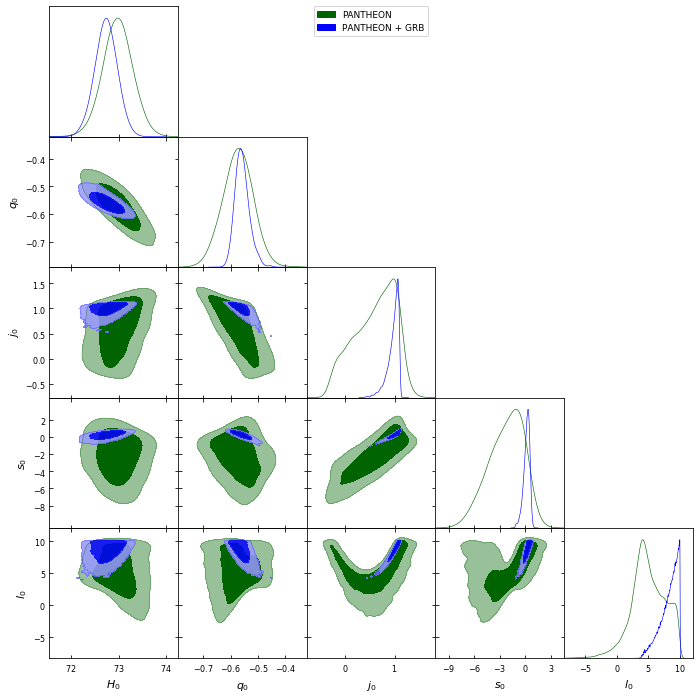

In [114]:
flat_samples_PantGRB4 = sampler_PantGRB4.get_chain(discard=15000, thin=15, flat=True)
samples_PantGRB4 = MCSamples(samples=flat_samples_PantGRB4, names = names_4, labels = names_4,\
                             label = 'PANTHEON + GRB')

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_Pant4, samples_PantGRB4], filled=True, contour_colors = ['darkgreen', 'blue'])

for i in range(ndim):
    mcmc = np.percentile(flat_samples_PantGRB4[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_4[i])
    display(Math(txt))

<font color='dcyan'>
    <font size=4>
        
## Determinación de parámetros libres de teorías con datos de supernovas

<font color='orange'>
    <font size=6>
        Modelos Cosmológicos

A pesar de que la cosmografía nos permite observar la cinemática del universo independiente de un modelo, también es de interés usar la dinámica observada para intentar restringir distintas teorías de Energía Oscura o Gravedad Modificada.

Por lo tanto ahora estudiaremos distintos Modelos Cosmológicos, para lo cual seguiremos el siguiente procedimiento:

1. Definir funciones de likelihood y priors, que deben ser específicos de cada modelo pues dependen de los parámetros libres de cada modelo.

2. Expresar los parámetros cosmográficos en términos de los parámetros libres del modelo. De esta manera se cuenta con una expresión de la distancia luminosa (y por lo tanto del módulo de distancia) en función de $z$ y de los parámetros libres de la teoría

3. Correr las cadenas de Markov y mostrar el espacio de parámetros y los valores estimados, con sus respectivas incertidumbres. En los casos en que uno o varios de los parámetros no queden bien determinados, se repite el procedimiento agregando un conjunto de datos, es decir se repite el procedimiento con PANTHEON + GRB/CC

# $\Lambda CDM$

In [44]:
def log_likelihood_LCDM(theta, z, mu, muerr):
    H0, OmLambda, M = theta
    model = mu_LCDM(z, H0, OmLambda, M)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

In [45]:
def log_prior_LCDM(theta):
    H0, OmL, OmM = theta
    if 50.0 < H0 < 150.0 and 0.0 < OmL < 1.0 and 0. < OmM < 1.:
        return 0.0
    return -np.inf

In [46]:
def log_probability_LCDM(theta, x, y, yerr):
    lp = log_prior_LCDM(theta)
    ll = log_likelihood_LCDM(theta, x, y, yerr)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    return lp + ll

#### Expansión cosmográfica

Uniendo las ecuaciones de Fridmann para el modelo $\Lambda$CDM con la evolución cosmográfica de $d_L(z)$, uno encuentra que
$$ 
q_0 = \dfrac{\Omega_m - 2\Omega_{\Lambda}}{2},
$$
y
$$
j_0 = \Omega_{\Lambda}+\Omega_m,
$$

$$
s_0 = (\Omega_{\Lambda}+\Omega_m)^2 - \frac{3}{2}  \Omega_m \big( -2 +5 \Omega_{\Lambda}+5\Omega_m\big)
$$

De esta manera podemos convertir nuestro modelo estadístico model-independent en un modelo cosmológico

In [47]:
def mu_LCDM(z, H0, OmLambda, M):
    q0 = (M-2*OmLambda)/2
    j0 = OmLambda + M
    s0 = (OmLambda + M)**2 - 3*M*(-2 + 5*(OmLambda + M))/2
    d = distance(z, H0, q0, j0, s0)
    mu = np.where(d>0, 5*np.log10(d)+25, -np.inf)
    return mu

In [48]:
initial_LCDM = np.array([61, 0.7, 0.3])
pos = initial_LCDM + 1e-5* np.random.randn(35, 3)
nwalkers, ndim = pos.shape

sampler_LCDM = emcee.EnsembleSampler(nwalkers, ndim, log_probability_LCDM, args=(z, mu, muerr))
sampler_LCDM.run_mcmc(pos, 15000, progress=True);

  0%|          | 32/15000 [00:00<02:26, 102.34it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
100%|██████████| 15000/15000 [02:07<00:00, 117.57it/s]


Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

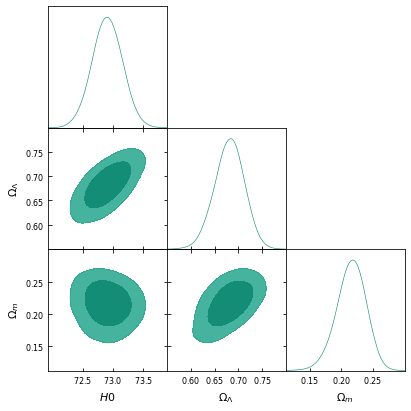

In [50]:
# Etiquetas de las variables
names_LCDM = ["H0", "\Omega_\Lambda", "\Omega_m"]

# Toma de espacio muestral
flat_samples_LCDM = sampler_LCDM.get_chain(discard=500, thin=15, flat=True)
samples_LCDM = MCSamples(samples=flat_samples_LCDM, names = names_LCDM, labels = names_LCDM)

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_LCDM], filled=True, contour_colors = [('#45B39D', '#138D75')])

#Valores estimados e incertidumbres
for i in range(3):
    mcmc = np.percentile(flat_samples_LCDM[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_LCDM[i])
    display(Math(txt))

# $w CDM$

In [5]:
def log_likelihood_wCDM(theta, z, mu, muerr):
    H0, Omm, Omw, w = theta
    model = mu_wCDM(z, H0, Omm, Omw, w)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

In [6]:
def log_prior_wCDM(theta):
    H0, Omm, Omw, w = theta
    if 50.0 < H0 < 150.0 and 0.0 < Omm < 1.0 and 0. < Omw < 1. and -3. < w < 0.:
        return 0.0
    return -np.inf

In [7]:
def log_probability_wCDM(theta, x, y, yerr):
    lp = log_prior_wCDM(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_wCDM(theta, x, y, yerr)

#### Expansión cosmográfica
$$ 
q_0 = \frac{1}{2} \big[ \Omega_m + \Omega_w ( 1 + 3w) \big],
$$
y
$$
j_0 = \frac{1}{2} \big[ 2 \Omega_m + \Omega_w \{2+9w(1+w)\} \big],
$$

$$
s_0 = \frac{1}{4} \big[ -2(6 + \Omega_m + \Omega_w)(\Omega_m + \Omega_w) - 3(22 +5\Omega_m +5 \Omega_w )\Omega_ww
- 9\Omega_w(12 +4 \Omega_w + \Omega_m)w^2
+ 27\Omega_w(−2 - Ω_w)w^3 \big].
$$

In [8]:
def mu_wCDM(z, H0, Omm, Omw, w):
    q0 = 0.5 * ( Omm + Omw*(1 + 3*w) )
    j0 = 0.5*( 2*Omm + Omw *(2+9*w*(1+w))) 
    s0 = 0.25*( -2*(6 + Omm + Omw)*(Omm + Omw) - 3*(22 + 5*(Omm + Omw))*Omw*w -\
               9*Omw*(12 + 4*Omw + Omm)*w**2 + 27*Omw*(-2 - Omw)*w**3)
    d = distance(z, H0, q0, j0, s0)
    mu = np.where(d>0, 5*np.log10(d)+25, -np.inf)
    return mu

In [9]:
initial = np.array([74, 0.3, 0.7, -1.])
pos = initial + 1e-4 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape

sampler_wCDM = emcee.EnsembleSampler(nwalkers, ndim, log_probability_wCDM, args=(z, mu, muerr))
sampler_wCDM.run_mcmc(pos, 15000, progress=True);

  2%|▏         | 363/15000 [00:03<02:09, 112.72it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
100%|██████████| 15000/15000 [02:09<00:00, 116.04it/s]


Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

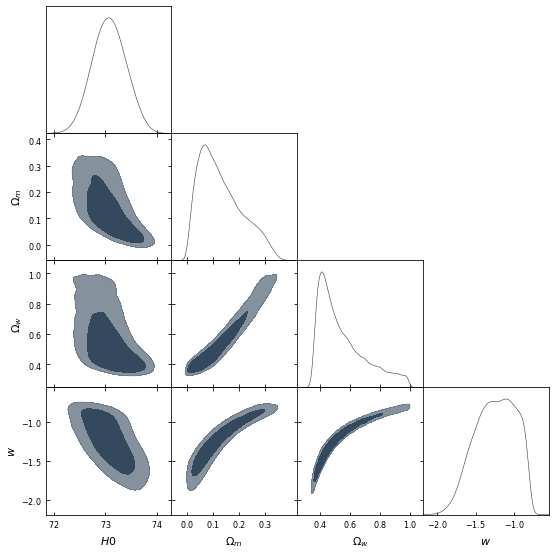

In [11]:
# Etiqueta de las variables
names_wCDM = ["H0", "\Omega_m", "\Omega_w", "w"]

# Tomamos la muestra
flat_samples_wCDM = sampler_wCDM.get_chain(discard=500, thin=15, flat=True)
samples_wCDM = MCSamples(samples=flat_samples_wCDM,names = names_wCDM, labels = names_wCDM)

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_wCDM], filled=True, contour_colors = [('#85929E', '#34495E')])

# Valores esperados
for i in range(4):
    mcmc = np.percentile(flat_samples_wCDM[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_wCDM[i])
    display(Math(txt))

# CPL ($k=0$)

In [8]:
def log_likelihood_CPL(theta, z, mu, muerr):
    H0, Omm, w0, wa = theta
    model = mu_CPL(z, H0, Omm, w0, wa)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

In [9]:
def log_prior_CPL(theta):
    H0, Omm, w0, wa = theta
    if 50.0 < H0 < 150.0 and 0.0 < Omm < 1.0 and -3. < w0 < 0. and -3. < wa < 3.:
        return 0.0
    return -np.inf

In [10]:
def log_probability_CPL(theta, x, y, yerr):
    lp = log_prior_CPL(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_CPL(theta, x, y, yerr)

#### Expansión cosmográfica

$$ 
q_0 = \frac{1}{2} + \frac{3}{2} (1 - \Omega_m) w_0 \ ,
$$

$$
j_0 = 1 + \frac{3}{2} (1 - \Omega_m) \left [ 3w_0 (1 + w_0) + w_{a}
\right ] \ ,
$$

$$
s_0 = -\frac{7}{2} - \frac{33}{4} (1 - \Omega_m) w_{a}
 -  \frac{9}{4} (1 - \Omega_m) \left [ 9 + (7 - \Omega_m)
w_{a} \right ] w_0 - \frac{9}{4} (1 - \Omega_m) 
 (16 - 3\Omega_m) w_0^2 - \frac{27}{4} (1 - \Omega_m) (3
- \Omega_m) w_0^3 \ ,
$$

In [11]:
def mu_CPL(z, H0, Omm, w0, wa):
    q0 = 0.5 * ( 1 + 3*w0*(1-Omm) )
    j0 = 1 + 1.5*(1-Omm)*(3*w0*(1+w0)+wa)
    s0 = 0.25*(-14 - 33*(1-Omm)*wa - 9*(1-Omm)*(9+wa*(7-Omm))*w0 -9*(1-Omm)*(16-3*Omm)*w0*w0 -\
              27*(1-Omm)*(3-Omm)*w0**3)
    d = distance(z, H0, q0, j0, s0)
    mu = np.where(d>0, 5*np.log10(d)+25, -np.inf)
    return mu

In [12]:
initial = np.array([74, 0.3, -1., 0.])
pos = initial + 1e-4 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape

sampler_CPL = emcee.EnsembleSampler(nwalkers, ndim, log_probability_CPL, args=(z, mu, muerr))
sampler_CPL.run_mcmc(pos, 15000, progress=True);

  0%|          | 59/15000 [00:00<02:12, 112.62it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
100%|██████████| 15000/15000 [02:16<00:00, 110.14it/s]


Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

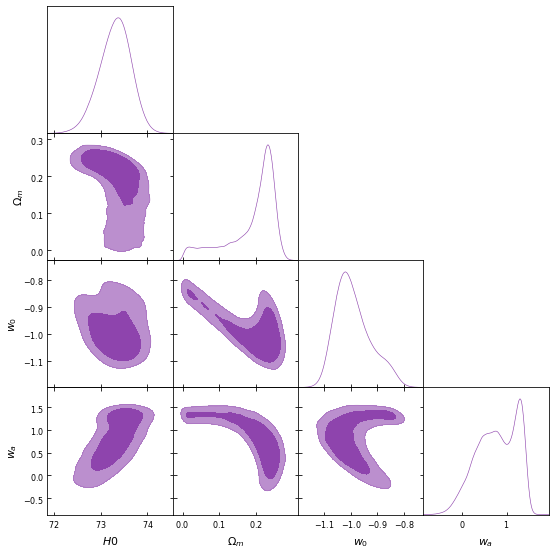

In [15]:
# Etiquetas
names_CPL = ["H0", "\Omega_m", "w_0", "w_a"]

# Muestra
flat_samples_CPL = sampler_CPL.get_chain(discard=5000, thin=15, flat=True)
samples_CPL = MCSamples(samples=flat_samples_CPL, names = names_CPL, labels = names_CPL)

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_CPL], filled=True, contour_colors = [('#BB8FCE', '#8E44AD')])

#Estimaciones
for i in range(4):
    mcmc = np.percentile(flat_samples_CPL[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_CPL[i])
    display(Math(txt))

# CPL $(k \neq 0)$

In [63]:
def log_likelihood_CPL_k(theta, z, mu, muerr):
    H0, Omm, Omw, w0, wa = theta
    model = mu_CPL_k(z, H0, Omm, Omw, w0, wa)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

In [64]:
def log_prior_CPL_k(theta):
    H0, Omm, Omw, w0, wa = theta
    if 50.0 < H0 < 150.0 and 0.0 < Omm < 1.0 and 0. < Omw < 1. and -3. < w0 < 0. and -3. < wa < 3.:
        return 0.0
    return -np.inf

In [65]:
def log_probability_CPL_k(theta, x, y, yerr, x2, y2, yerr2):
    lp = log_prior_CPL_k(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_CPL_k(theta, x, y, yerr) + log_likelihood_CPL_k(theta, x2, y2, yerr2)

In [66]:
def log_probability_CPL_k_Pant(theta, x, y, yerr):
    lp = log_prior_CPL_k(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_CPL_k(theta, x, y, yerr)

#### Expansión cosmográfica

$$ 
q_0 = \frac{1}{2} \big[ \Omega_m + \Omega_w ( 1 + 3w_0) \big],
$$

$$
j_0 = \frac{1}{2} \big[ 2 \Omega_m + \Omega_w \{2+9w_0(1+w_0) + 3w_1\} \big],
$$

$$
s_0 = \frac{1}{4} \big[ -14  + (\Omega_m + \Omega_w - 1)(1 + 3w_0)(-16+3w_0( -16 + 5 \Omega_m + 6(-2 + \Omega_m)w_0)) \\- 9(-1 +\Omega_m  )w_0(-9 + w_0(-16 -9w_0 + 3\Omega_m(1+w_0))) - 33w_1 + 3(-1 + \Omega_m + \Omega_w)(-12 + \Omega_m + 6(-4 + \Omega_m)w_0)w_1 \\
+3(11\Omega_m - 3(-7+\Omega_m)(-1 + \Omega_m)w_0)w_1 - (\Omega_m + \Omega_w -1)^2(1+3w_0)(2 +9w_0(1+w_0)+3w_1) \big].
$$

In [67]:
def mu_CPL_k(z, H0, Omm, Omw, w0, w1):
    q0 = 0.5 * ( Omm + Omw*(1 + 3*w0) )
    j0 = 0.5*( 2*Omm + Omw *(2+9*w0*(1+w0) +3*w1)) 
    s0 = 0.25*( -14 + (Omm + Omw -1)*(1+3*w0)*(-16 + 3*w0*(-16 + 5*Omm + 6*(-2 + Omm)*w0)) -\
              9*(-1+Omm)*w0*(-9+w0*(-16-9*w0+3*Omm*(1+w0)))-33*w1+3*(-1+Omm+Omw)*(-12+Omm+6*(-1+Omm)*w0)*w1 +\
              3*(11*Omm-3*(-7+Omm)*(-1+Omm)*w0)*w1 - ((Omm+Omw-1)**2)*(1+3*w0)*(2+9*w0*(1+w0)+3*w1))
    d = distance(z, H0, q0, j0, s0)
    mu = np.where(d>0, 5*np.log10(d)+25, -np.inf)
    return mu

In [68]:
initial = np.array([72, 0.3, 0.7, -1., 0.])
pos = initial + 1e-1 * np.random.randn(35, 5)
nwalkers, ndim = pos.shape

sampler_CPLkPant = emcee.EnsembleSampler(nwalkers, ndim, log_probability_CPL_k_Pant,\
                                     args=(z, mu, muerr))
sampler_CPLkPant.run_mcmc(pos, 80000, progress=True);

  0%|          | 0/80000 [00:00<?, ?it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
100%|██████████| 80000/80000 [10:31<00:00, 126.62it/s]


In [69]:
initial = np.array([72, 0.3, 0.7, -1., 0.])
pos = initial + 1e-1 * np.random.randn(35, 5)
nwalkers, ndim = pos.shape

sampler_CPLk = emcee.EnsembleSampler(nwalkers, ndim, log_probability_CPL_k,\
                                     args=(z, mu, muerr, zGRB, muGRB, muerrGRB))
sampler_CPLk.run_mcmc(pos, 80000, progress=True);

/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
  0%|          | 0/80000 [00:00<?, ?it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 80000/80000 [16:35<00:00, 80.38it/s]


In [71]:
names_CPLk = ["H_0", "\Omega_m", "\Omega_w", "w_0", "w_a"]

flat_samples_CPLkPant = sampler_CPLkPant.get_chain(discard=40000, thin=15, flat=True)
samples_CPLkPant = MCSamples(samples=flat_samples_CPLkPant,names = names_CPLk, labels = names_CPLk,\
                            label = 'PANTHEON')

# Estimaciones
for i in range(ndim):
    mcmc = np.percentile(flat_samples_CPLkPant[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_CPLk[i])
    display(Math(txt))

Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

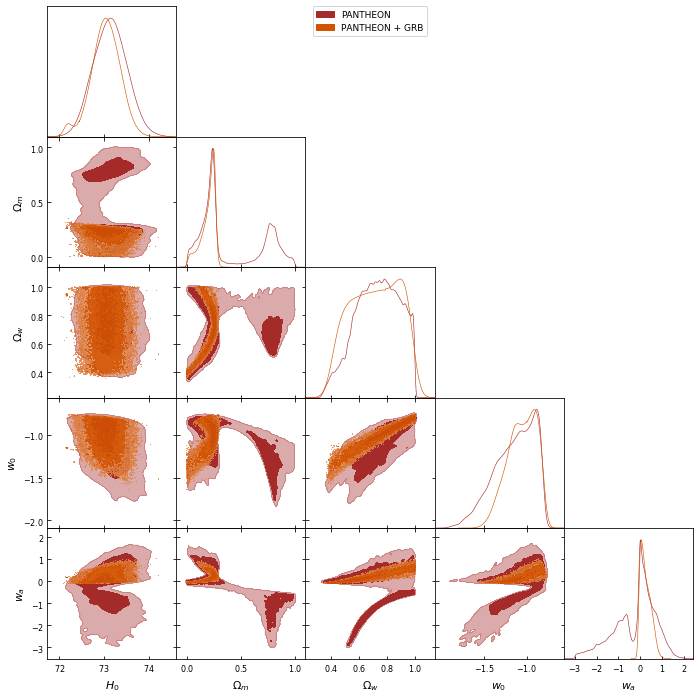

In [72]:
flat_samples_CPLk = sampler_CPLk.get_chain(discard=40000, thin=15, flat=True)
samples_CPLk = MCSamples(samples=flat_samples_CPLk,names = names_CPLk, labels = names_CPLk,
                        label ='PANTHEON + GRB')

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_CPLkPant, samples_CPLk], filled=True, contour_colors = ['brown', ('#E59866', '#D35400')])

# Estimaciones
for i in range(ndim):
    mcmc = np.percentile(flat_samples_CPLk[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_CPLk[i])
    display(Math(txt))

<font color='orange'>
    <font size=6>
        Padé y Chebyshev

## Padé

Aproximamos el parámetro adimensional de Hubble por un polinomio de Padé

$$ \dfrac{H(z)}{H_0} \approx P_{2,2}(z)= \frac{1+P_{1}z+P_{2}z^{2}}{1+Q_{1}z+Q_{2}z^{2}}, $$



Que se traduce a una ecuación de estado con
     
$$
w(z)_{\text{Padé}}=-1+ \frac{(z+1) \left[P_1 \left(1-Q_2 z^2\right)+P_2 z \left(Q_1 z+2\right)-P_0 \left(2 Q_2
   z+Q_1\right)\right]}{3 \left[z \left(P_2 z+P_1\right)+P_0\right) \left(z \left(Q_2
   z+Q_1\right)+1\right]}, 
$$

In [73]:
def log_likelihood_Pade(theta, z, mu, muerr):
    H0, Omm, Omp, P1, P2, Q1, Q2 = theta
    model = mu_Pade(z, H0, Omm, Omp, P1, P2, Q1, Q2)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

In [74]:
def log_prior_Pade(theta):
    H0, Omm, Omp, P1, P2, Q1, Q2 = theta
    if 50.0 < H0 < 150.0 and 0.0 < Omm < 1.0 and 0. < Omp < 1. and -3. < P1 < 0. and -3. < P2 < 3. and \
    -4. < Q1 < 4. and -4. < Q2 < 4.:
        return 0.0
    return -np.inf

In [75]:
def log_probability_Pade(theta, x, y, yerr):
    lp = log_prior_Pade(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_Pade(theta, x, y, yerr)

#### Expansión cosmográfica

$$
q_{0}= \frac{3 \Omega _m+\Omega _p \left(-P_1-Q_1\right)}{2 \left(\Omega _m+\Omega _p\right)}-1,\\
j_0= \frac{\Omega _p \left[P_1 \left(Q_1+1\right)+P_2+Q_1 \left(Q_1+1\right)-Q_2\right]}{\Omega _m+\Omega_p}+1,\\
s_0 = 1-\frac{\Omega _m+\Omega _p \left[-\left(P_1+1\right) Q_1-P_2 Q_1 +Q_1 \left[Q_1\left(-\left(P_1+Q_1\right)\right)-Q_1\right]+Q_2 \left(P_1+2Q_1\right)+Q_2 - \left(P_1+P_2\right)\right]}{\Omega _m+\Omega _p} .
$$

In [76]:
def mu_Pade(z, H0, Omm, Omp, P1, P2, Q1, Q2):
    q0 = (3*Omm - Omp*(P1 + Q1))/(2*(Omm + Omp)) -1
    j0 = (Omp*(P1*(Q1 +1) + P2 + Q1*(Q1 + 1) - Q2))/((Omm + Omp)) +1 
    s0 = 1 - ( Omm + Omp*(-Q1*(Q1 +1) - P2*Q1 + Q1*(-Q1*(P1 + Q1 +1)) + Q2*(P1 + 2*Q1 +1) -\
                          1*(P1 + P2)))/((Omm + Omp))
    d = distance(z, H0, q0, j0, s0)
    mu = np.where(d>0, 5*np.log10(d)+25, -np.inf)
    return mu

In [77]:
initial = np.array([74, 0.3, 0.7, 0., 0., 0., 0.])
pos = initial + 1e-4 * np.random.randn(35, 7)
nwalkers, ndim = pos.shape

sampler_Pade = emcee.EnsembleSampler(nwalkers, ndim, log_probability_Pade, args=(z, mu, muerr))
sampler_Pade.run_mcmc(pos, 100000, progress=True);

  0%|          | 0/100000 [00:00<?, ?it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 440/100000 [00:02<10:01, 165.62it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
100%|██████████| 100000/100000 [10:23<00:00, 160.33it/s]


Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

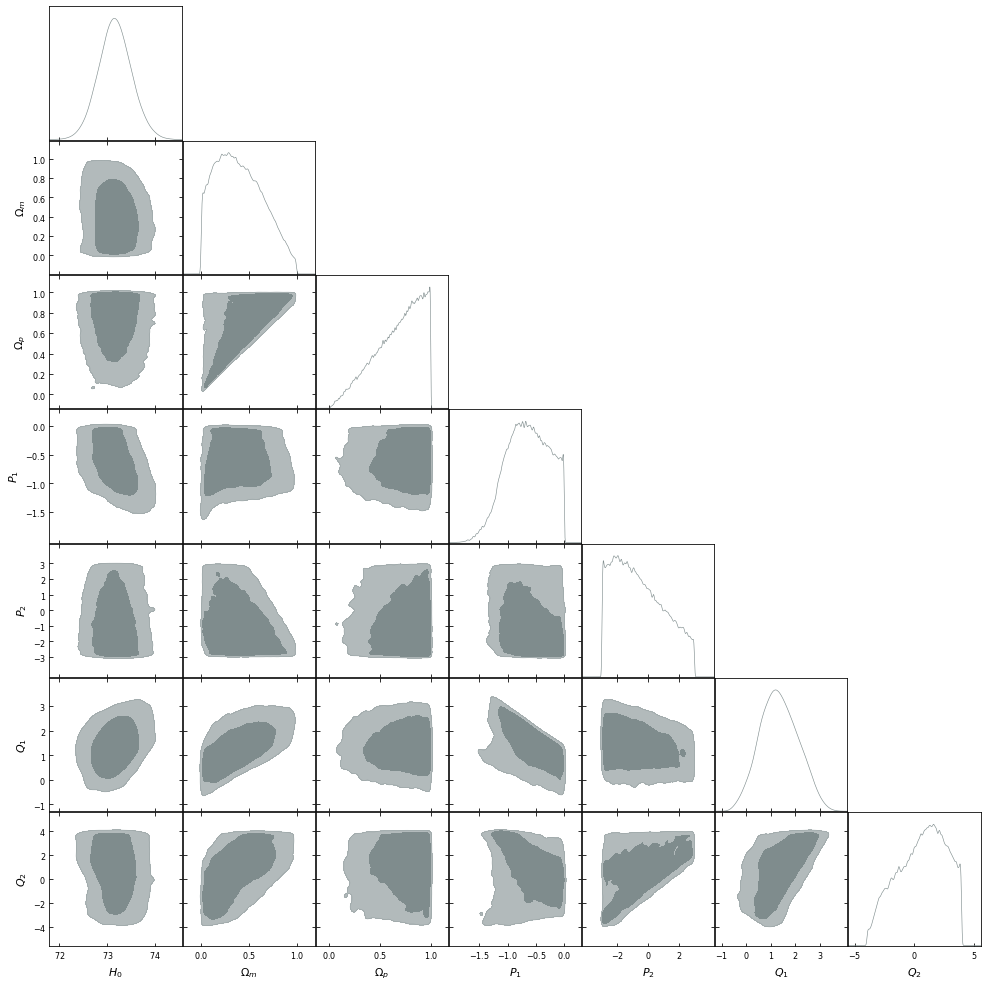

In [79]:
names_Pade = ["H_0", "\Omega_m", "\Omega_p", "P_1", "P_2", "Q_1", "Q_2"]

flat_samples_Pade = sampler_Pade.get_chain(discard=0, thin=15, flat=True)
samples_Pade = MCSamples(samples=flat_samples_Pade, names = names_Pade, labels = names_Pade)

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_Pade], filled=True, contour_colors = [('#B2BABB', '#7F8C8D')])

# Estimaciones
for i in range(ndim):
    mcmc = np.percentile(flat_samples_Pade[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_Pade[i])
    display(Math(txt))

## Chebyshev

Aproximamos el parámetro adimensional de Hubble por un polinomio de Chebyshev

$$ \dfrac{H(z)}{H_0} \approx R_{2,1}(z)= \frac{a_3 +a_1 z +2a_2 z^2}{1+b_1 z}, $$



Donde $a_3 = a_0 - a_2$. Esto se traduce a una ecuación de estado con
     
$$
w(z)_{\text{Chebyshev}}=-1+ \frac{\left[2 a_2 z \left(b_1 z+2\right)-a_3 b_1+a_1\right](z+1)}{3 \left(z \left(2 a_2
   z+a_1\right)+a_3\right) \left(b_1 z+1\right)},
$$

In [80]:
def log_likelihood_Cheb(theta, z, mu, muerr):
    H0, Omm, Omp, a1, a2, b1, a3 = theta
    model = mu_Cheb(z, H0, Omm, Omp, a1, a2, b1, a3)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

In [81]:
def log_prior_Cheb(theta):
    H0, Omm, Omp, a1, a2, b1, a3 = theta
    if 50.0 < H0 < 150.0 and 0.0 < Omm < 1.0 and 0. < Omp < 1. and -3. < a1 < 0. and -3. < a2 < 3. and \
    -4. < b1 < 4. and -4. < a3 < 4.:
        return 0.0
    return -np.inf

In [82]:
def log_probability_Cheb(theta, x, y, yerr):
    lp = log_prior_Cheb(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_Cheb(theta, x, y, yerr)

#### Expansión cosmográfica

$$
q_{0}= \frac{\left(a_1-a_3 b_1\right) \Omega _p+3 \Omega _m}{2 \left(a_3 \Omega _p+\Omega _m\right)}-1,\\
j_0= \frac{\left[a_1 \left(-b_1-1\right)+a_3 b_1 \left(b_1+1\right)+2 a_2+a_3\right] \Omega _p+\Omega
   _m}{a_3 \Omega _p+\Omega _m}, \\
s_0 = \frac{\left[-a_1 \left(b_1+1\right)+a_3 b_1 \left(b_1+1\right)+2 a_2+a_3\right] \Omega _p+\Omega
   _m}{a_3 \Omega _p+\Omega _m}.
$$

In [83]:
def mu_Cheb(z, H0, Omm, Omp, a1, a2, b1, a3):
    q0 = (Omp*(a1-a3*b1)+3*Omm)/(2*(Omm + a3*Omp)) -1
    j0 = (Omp*(-1*a1*(b1+1) + a3*b1*(b1 + 1) + 2*a2 + a3) + Omm)/((Omm + a3*Omp)) 
    s0 = (Omp*(-1*a1*(b1+1) + a3*b1*(b1 + 1) + 2*a2 + a3) + Omm)/((Omm + a3*Omp)) 
    d = distance(z, H0, q0, j0, s0)
    mu = np.where(d>0, 5*np.log10(d)+25, -np.inf)
    return mu

In [84]:
initial = np.array([74, 0.3, 0.7, 0., 0., 0., 0.])
pos = initial + 1e-4 * np.random.randn(35, 7)
nwalkers, ndim = pos.shape

sampler_Cheb = emcee.EnsembleSampler(nwalkers, ndim, log_probability_Cheb, args=(z, mu, muerr))
sampler_Cheb.run_mcmc(pos, 100000, progress=True);

  0%|          | 0/100000 [00:00<?, ?it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 33/100000 [00:00<10:08, 164.31it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
100%|██████████| 100000/100000 [09:25<00:00, 176.71it/s]


Removed no burn in


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

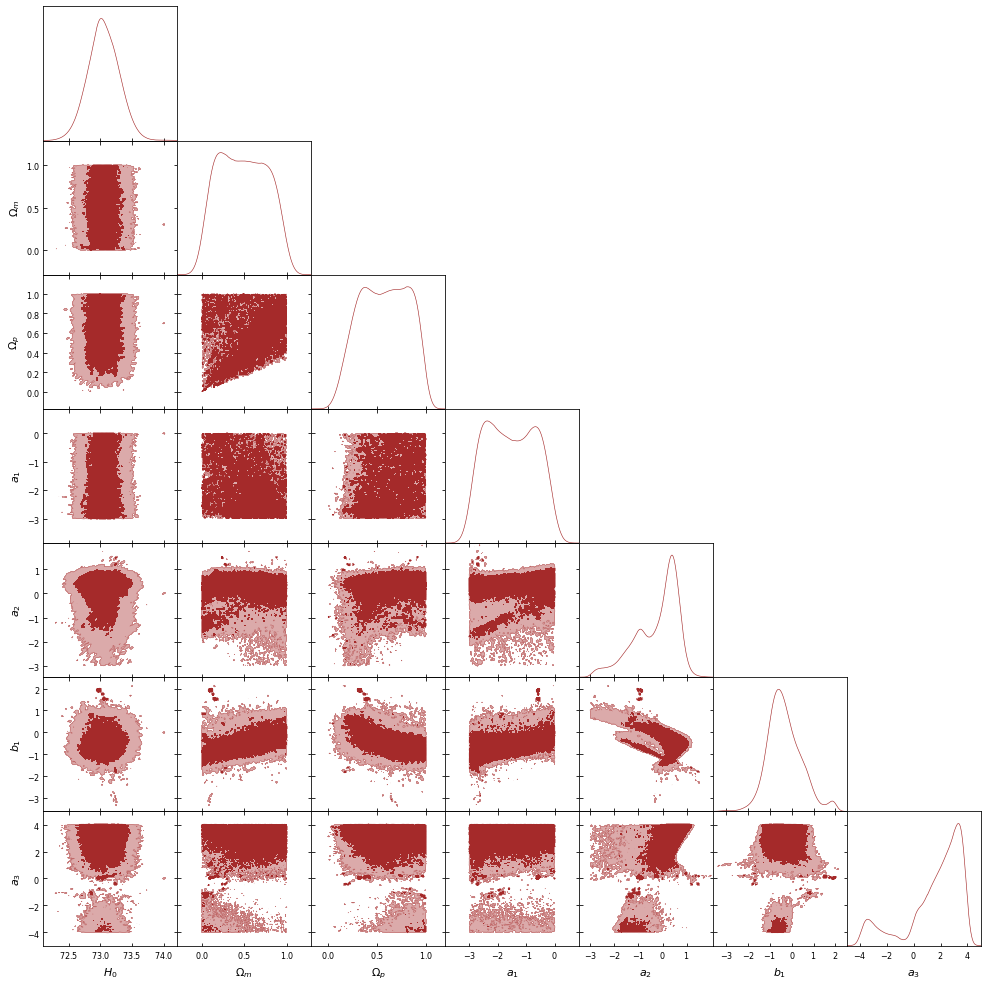

In [86]:
names_Cheb = ["H_0", "\Omega_m", "\Omega_p", "a_1", "a_2", "b_1", "a_3"]

flat_samples_Cheb = sampler_Cheb.get_chain(discard=20000, thin=15, flat=True)
samples_Cheb = MCSamples(samples=flat_samples_Cheb,names = names_Cheb, labels = names_Cheb)

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_Cheb], filled=True, contour_colors = ['brown'])

for i in range(ndim):
    mcmc = np.percentile(flat_samples_Cheb[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_Cheb[i])
    display(Math(txt))

<font color='orange'>
    <font size=6>
        Gravedad Modificada

# $f(R)$

Introducir teorías de gravedad modificada a

$$ d_L(z)=\dfrac{c}{H_0}z\bigg[1-\dfrac{f_0 + 2H_0^2}{4H_0^2}z + \dfrac{9f_0^2 + 2(36f_0-f_{z0})H_0^2 + 108 H_0^4}{74H_0^4} z^2+ \dfrac{-45f_0^3+18f_0(-32f_0 + f_{z0})H_0^2 - 4 (567f_0 - 21f_{z0} + f_{2z0})H_0^4 - 2592H_0^6}{576H_0^6} z^3 + \mathcal{O}(z^4) \bigg]$$

In [87]:
def distance_fR(z, H0, f0, f10, f20):
    term1 = (f0*1e5) + 2*H0**2
    term2 = 9*(f0*1e5)**2 + 2*(36*(f0*1e5)-(f10*1e5))*H0**2 + 108*H0**4
    term3 = -45*(f0*1e5)**3 + 18*(f0*1e5)*(-32*(f0*1e5) + (f10*1e5))*H0**2 -\
    4*(567*(f0*1e5) - 21*(f10*1e5) + (f20*1e5))*H0**4 - 2592*H0**6
    d_L = (3e5/H0) * z * (1 - z*term1/(4*H0**2) + z**2 *term2/(74*H0**4) + z**3 *term3 /(576*H0**6))
    mu = np.where(d_L>0, 5*np.log10(d_L)+25, -np.inf)
    return mu

In [88]:
def log_likelihood_fR(theta, z, mu, muerr):
    H0, f0, f10, f20 = theta
    model = distance_fR(z, H0, f0, f10, f20)
    sigma2 = muerr ** 2
    return -0.5 * np.sum((mu - model) ** 2 / sigma2 + np.log(sigma2))

In [89]:
def log_prior_fR(theta):
    H0, f0, f10, f20 = theta
    if 50.0 < H0 < 150.0 and -10.0 < f0 < 10.0 and -10. < f10 < 10. and -10. < f20 < 10.:
        return 0.0
    return -np.inf

In [90]:
def log_probability_fR(theta, x, y, yerr):
    lp = log_prior_fR(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_fR(theta, x, y, yerr)

In [91]:
initial = np.array([74, -0.3, 0.3, -3])
pos = initial + 1e-1 * np.random.randn(35, 4)
nwalkers, ndim = pos.shape

sampler_fR = emcee.EnsembleSampler(nwalkers, ndim, log_probability_fR, args=(z, mu, muerr))
sampler_fR.run_mcmc(pos, 30000, progress=True);

/home/carlo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
  0%|          | 0/30000 [00:00<?, ?it/s]/home/carlo/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 30000/30000 [04:21<00:00, 114.63it/s]


Removed no burn in


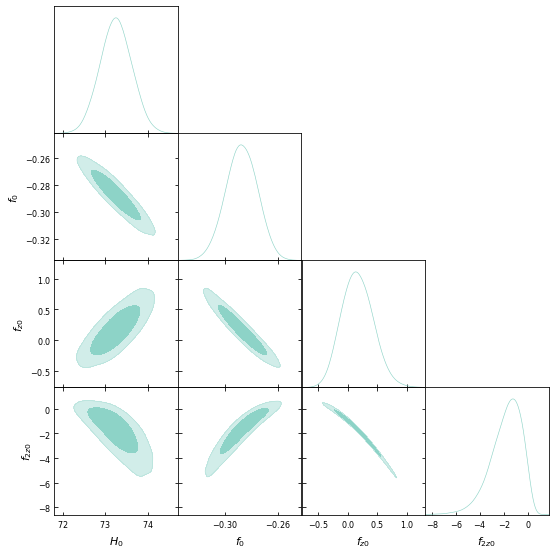

In [93]:
names_fR = ["H_0", "f_0", "f_{z0}", "f_{2z0}"]

flat_samples_fR = sampler_fR.get_chain(discard=3000, thin=15, flat=True)
samples_fR = MCSamples(samples=flat_samples_fR, names = names_fR, labels = names_fR)

# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples_fR], filled=True, contour_colors = 'Set3')

In [94]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples_fR[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], names_fR[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>